# Deep Object Detection with OpenCV
The Fast-Rcnn paper came out in April 2015 which used convolutional neural networks for generating object proposals in place of selective search and within a couple of months, we had Faster-RCNN which improved the speed and around the same time we had YOLO-v1 which didn’t look at object detection as a classification problem. In Dec 2015, we met single shot object detectors which were very impressive due to their speed and accuracy. After that YOLO-v2, Mask-RCNN, Retinanet(focal loss), YOLO-v3 all of them have pushed the limit of previous methods either in terms of accuracy or speed.
<img src="OpenCV_object_detection/state-of-the-art-in-object-detection.jpg" style="width:600px;height:200px">
<caption><center> <u> <font color='purple'> Figure 1: State-of-the-art in object detection from [1]</font></u></center></caption>

OpenCV decided to watch from the sidelines while the war was going on. Once, the skies are a little bit clear, OpenCV has introduced the flexibility of deploying deep learning models trained on other frameworks in OpenCV. Currently, it supports **Caffe**, **Torch**, **Tensorflow**, and **Darknet**. This is especially useful if you have deployed OpenCV based model say Hog+SVM classifier or Haar cascade based detector etc. in production and you want to replace it with a more accurate appropriate deep learning based model.  So, you can train your models in your favorite deep learning library and deploy that model in your production infrastructure without disrupting your current workflow.

## Yolo-v2 Trained on Ms Coco
In this section, we shall deploy the YOLO-v2 model for object detection which is trained on mscoco detection dataset which has 80 classes. These weights have been trained in darknet which is an open sourced neural network framework written in C. But, we don’t need to worry about darknet. All of this has been handled by OpenCV for us. We shall use the `cv2.dnn.readNetFromDarknet()` method to load the saved weights into the network.

The next step is to load images in a batch and run them through the network. For this, we use the `cv2.dnn.blobFromImage` method. This method creates 4-dimensional blob from input images (<a href="http://cv-tricks.com/how-to/running-deep-learning-models-in-opencv/">details of this function</a>). YOLO-V2 model needs input images in the size of (416,416) and scales the images by dividing them by 255. So, here is how we use it:




In [1]:
# make sure that jupyter sees OpenCV
import os, sys
sys.path.append("/home/meshgi-k/anaconda3/envs/opencv/lib/python3.6/site-packages/cv2")
import cv2
print ("OpenCV Version : %s " % cv2.__version__)


OpenCV Version : 3.4.1 


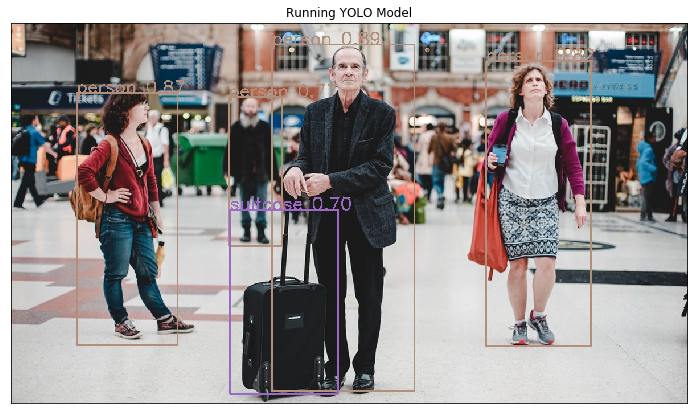

In [40]:
import cv2
import argparse
import numpy as np
import os, sys
from matplotlib import pyplot as plt



#function definition
# """
# Compute sigmoid of x.
# Arguments:
# x -- A scalar
# Return:
# s -- sigmoid(x)
# """

# Minimum confidence threshold. Increasing this will improve false positives but will also reduce detection rate.
min_confidence=0.14
model = 'public_models/yolov2_mscoco.weights'
config = 'public_models/yolov2_mscoco.cfg'


#Load names of classes
classes = None
with open('public_models/yolov2_mscoco.labels', 'r') as f:
    classes = f.read().rstrip('\n').split('\n')

# Load weights and construct graph
net = cv2.dnn.readNetFromDarknet(config, model)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_DEFAULT)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

plt.figure(figsize=(15, 7))
plt.title('Running YOLO Model')
# winName = 'Running YOLO Model'
# cv2.namedWindow(winName, cv2.WINDOW_NORMAL)

#Read input image
frame = cv2.imread('OpenCV_object_detection/test.jpg')
# frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# plt.imshow(frame_rgb)
# plt.show()

# Get width and height
height,width,ch=frame.shape

# Create a 4D blob from a frame.
# blob = cv.dnn.blobFromImage(image, scale_factor, size, subtract_mean, swap_RB=True, center_crop)
blob = cv2.dnn.blobFromImage(frame, 1.0/255.0, (416, 416), True, crop=False)
net.setInput(blob)

#Color codes
colors = np.zeros([80, 3], np.uint8)
colors = np.floor((np.random.random((80, 3))*0.6+0.4)*255)

# Run the preprocessed input blog through the network
predictions = net.forward()
probability_index=5

for i in range(predictions.shape[0]):
    prob_arr=predictions[i][probability_index:]
    class_index=prob_arr.argmax(axis=0)
    confidence= prob_arr[class_index]
    if confidence > min_confidence:
        x_center=predictions[i][0]*width
        y_center=predictions[i][1]*height
        width_box=predictions[i][2]*width
        height_box=predictions[i][3]*height
     
        x1=int(x_center-width_box * 0.5)
        y1=int(y_center-height_box * 0.5)
        x2=int(x_center+width_box * 0.5)
        y2=int(y_center+height_box * 0.5)
     
        c = tuple(colors[class_index])
        cv2.rectangle(frame,(x1,y1),(x2,y2),tuple(c),2)
        cv2.putText(frame,classes[class_index]+" "+"{0:.2f}".format(confidence),(x1,y1), cv2.FONT_HERSHEY_SIMPLEX, 1,tuple(c),2)
        cv2.imwrite("OpenCV_object_detection/output/out_test.jpg", frame)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame_rgb)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
import cv2
import argparse
import numpy as np
import os, sys
from matplotlib import pyplot as plt


def opencv_yolo2_obj_detector (model_path, config_path, labels_path, image, min_confidence, bbox_colors, draw_bbox = True):
    """
    Use OpenCV wrapper for DarkNet Yolo_v2 for object recognition

    Arguments:
    model_path --
    config_path --
    labels_path -- 
    image -- 
    min_confidence -- A threshold for discarding
    bbox_colors -- 
    draw_bbox --

    Return:
    bboxes -- A tuple of (x1,y1,x2,y2,all_class_probabilities,predicted_class_index,predicted_class_name,predicted_class_confidence)
    output_img -- An annotated image
    """

    #Load names of classes
    classes = None
    with open(labels_path, 'r') as f:
        classes = f.read().rstrip('\n').split('\n')

    # Load weights and construct graph
    net = cv2.dnn.readNetFromDarknet(config, model)
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_DEFAULT)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

    # Get width and height
    frame = image
    height,width,ch=frame.shape

    # Create a 4D blob from a frame.
    # blob = cv.dnn.blobFromImage(image, scale_factor, size, subtract_mean, swap_RB=True, center_crop)
    blob = cv2.dnn.blobFromImage(frame, 1.0/255.0, (416, 416), True, crop=False)
    net.setInput(blob)    

    # Run the preprocessed input blog through the network
    predictions = net.forward()
    probability_index=5

    for i in range(predictions.shape[0]):
        prob_arr=predictions[i][probability_index:]
        class_index=prob_arr.argmax(axis=0)
        confidence= prob_arr[class_index]
        if confidence > min_confidence:
            x_center=predictions[i][0]*width
            y_center=predictions[i][1]*height
            width_box=predictions[i][2]*width
            height_box=predictions[i][3]*height

            x1=int(x_center-width_box * 0.5)
            y1=int(y_center-height_box * 0.5)
            x2=int(x_center+width_box * 0.5)
            y2=int(y_center+height_box * 0.5)

            if (draw_bbox):
                c = tuple(colors[class_index])
                cv2.rectangle(frame,(x1,y1),(x2,y2),tuple(c),2)
                cv2.putText(frame,classes[class_index]+" "+"{0:.2f}".format(confidence),(x1,y1), cv2.FONT_HERSHEY_SIMPLEX, 1,tuple(c),2)
                cv2.imwrite("OpenCV_object_detection/output/out_test.jpg", frame)
    if (draw_bbox):
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        frame_rgb = None
        
    

In [43]:
# Unit test for opencv_yolo2_obj_detector
     
import cv2
plt.figure(figsize=(15, 7))
plt.title('Running YOLO Model')
# winName = 'Running YOLO Model'
# cv2.namedWindow(winName, cv2.WINDOW_NORMAL)

#Read input image
frame = cv2.imread('OpenCV_object_detection/test.jpg')
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame_rgb)
plt.show()

#Color codes
colors = np.zeros([80, 3], np.uint8)
colors = np.floor((np.random.random((80, 3))*0.6+0.4)*255)

# Minimum confidence threshold. Increasing this will improve false positives but will also reduce detection rate.
opencv_yolo2_obj_detector (model_path = 'public_models/yolov2_mscoco.weights', 
                           config_path = 'public_models/yolov2_mscoco.cfg', 
                           labels_path = 'public_models/yolov2_mscoco.labels', 
                           image = frame, 
                           min_confidence = 0.14, 
                           bbox_colors = colors, 
                           draw_bbox = True)



plt.imshow(frame_rgb)
plt.xticks([])
plt.yticks([])
plt.show()

NameError: name 'colormap' is not defined

In [ ]:
# Make a GIF from video


# Installation Guide
Install `OpenCV` and some utilities

```
conda install -c conda-forge opencv
conda install -c conda-forge/label/broken opencv
pip install imutils
pip install cython
pip install opencv-python
```

If OpenCV2 is visible in command line Python but not available in Jupyter Notebook do this:
- In command line:

```
$ python
>>> import cv2
>>> cv2
<module 'cv2.cv2' from '[PATH-TO-CV2-PACKAGE]/cv2.cpython-36m-x86_64-linux-gnu.so'>
```

- Before importing cv2 in Jupyter Notebook add these lines
```
import sys
sys.path.append("[PATH-TO-CV2-PACKAGE]")
import cv2
print ("OpenCV Version : %s " % cv2.__version__)
```

Install `dlib` with GPU support
```
git clone https://github.com/davisking/dlib.git
cd dlib
mkdir build
cd build
cmake .. -DUSE_AVX_INSTRUCTIONS=1
cmake --build .
cd ..
python setup.py install --yes USE_AVX_INSTRUCTIONS
```
Install `face_recognition`
```
pip install face_recognition
```

## Note on Showing OpenCV Images with Matplotlib
An image is loaded by `OpenCV` as a `numpy` array, but the color of each pixel has been sorted as BGR.
`Matplotlib`'s plot expects an RGB image so, for a correct display of the image, it is necessary to swap those channels. This operation can be done by using `OpenCV` conversion functions `cv2.cvtColor()`, by working directly with the numpy array, or by using helper functions from `imutils` library.

```
# INCORRECT: show the image without converting color spaces
plt.figure("Incorrect")
plt.imshow(img)
 
# CORRECT: convert color spaces before using plt.imshow
plt.figure("Correct")
plt.imshow(imutils.opencv2matplotlib(img))
plt.show()
```
or use this 
```
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
```
from <a href="https://giusedroid.blogspot.com/2015/04/blog-post.html">here</a> and <a href="https://www.pyimagesearch.com/2015/02/02/just-open-sourced-personal-imutils-package-series-opencv-convenience-functions/"> here</a>

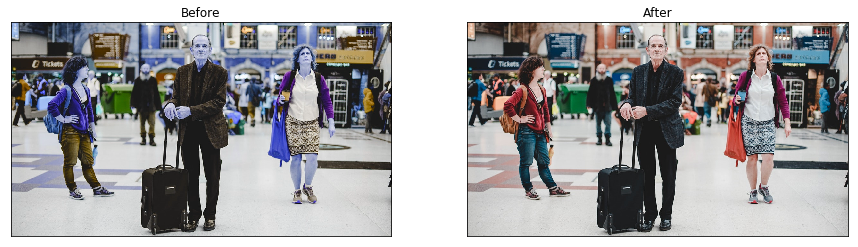

In [13]:
frame = cv2.imread('OpenCV_object_detection/test.jpg')
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 7))
subplot = plt.subplot(1, 2, 1)
subplot.imshow(frame)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.set_title('Before')
subplot = plt.subplot(1, 2, 2)
subplot.imshow(frame_rgb)
subplot.set_xticks([])
subplot.set_yticks([])
subplot.set_title('After')

plt.show()

# References
[1] CV Tricks Running Deep Learning models in OpenCV http://cv-tricks.com/how-to/running-deep-learning-models-in-opencv/

[2] PyImageSearch Face recognition with OpenCV, Python, and deep learning https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/